In [ ]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

### FOR CONVERTING RSML TO TIF ###
def parse_rsml_no_ns(file_path):
    """
    Parses an RSML file without namespaces and extracts polyline coordinates.
    Returns a list of lists of (x, y) points.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    roots = []
    for polyline in root.findall('.//polyline'):
        points = []
        for point in polyline.findall('./point'):
            x = float(point.get('x'))
            y = float(point.get('y'))
            points.append((x, y))
        roots.append(points)

    return roots


def draw_roots_to_mask(roots, shape):
    """
    Draws binary root mask from polyline coordinates.
    Returns a binary mask (numpy array).
    """
    mask = np.zeros(shape[:2], dtype=np.uint8)

    for root in roots:
        pts = np.array(root, dtype=np.int32)
        for i in range(len(pts) - 1):
            pt1 = tuple(pts[i])
            pt2 = tuple(pts[i + 1])
            cv2.line(mask, pt1, pt2, color=255, thickness=1)

    return mask


def process_rsml_directory(input_dir, output_dir):
    """
    Processes all .rsml files in input_dir and saves binary .tif masks to output_dir.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    rsml_files = [f for f in os.listdir(input_dir) if f.endswith('.rsml')]

    for rsml_file in tqdm(rsml_files, desc="Processing RSML files"):
        rsml_path = os.path.join(input_dir, rsml_file)
        image_path = rsml_path.replace('.rsml', '.png')
        image_path = os.path.join(input_dir, os.path.basename(image_path))

        if not os.path.exists(image_path):
            print(f"Skipping {rsml_file}: Corresponding image not found.")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {rsml_file}: Image could not be loaded.")
            continue

        roots = parse_rsml_no_ns(rsml_path)
        mask = draw_roots_to_mask(roots, image.shape)

        mask_filename = os.path.splitext(rsml_file)[0] + '.tif'
        mask_output_path = os.path.join(output_dir, mask_filename)
        cv2.imwrite(mask_output_path, mask)


# === Use the function with specified input/output directories ===
input_directory = "data_v1_raw/test"
output_directory = "data_v1_unprocessed/test"

process_rsml_directory(input_directory, output_directory)

In [37]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

### FOR INVERTING PIXEL INTENSITIES
def invert_images_in_place(directory):
    """
    Inverts pixel intensities of all PNG images in the given directory,
    overwriting the original files.

    Parameters:
    - directory (str): Path to the directory containing .png images.
    """
    png_files = [f for f in os.listdir(directory) if f.lower().endswith('.png')]

    for file in tqdm(png_files, desc="Inverting images in-place"):
        file_path = os.path.join(directory, file)

        image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            print(f"Skipping {file}: Could not read image.")
            continue

        inverted = 255 - image
        cv2.imwrite(file_path, inverted)

invert_images_in_place("images")

Inverting images in-place: 100%|██████████| 60/60 [00:17<00:00,  3.43it/s]


In [3]:
import cv2
from preprocess import crop, padder, crop_to_coordinates
from patchify import patchify
import os
import numpy as np
import matplotlib.pyplot as plt

patch_size = 256

def patch_dataset(dataset_path, patched_dataset_path):
    subdirs = ['val']
    
    for subdir in subdirs:
        # Create the corresponding patched directory
        patched_subdir = os.path.join(patched_dataset_path, subdir)

        # Get the full path to the original subdirectory
        original_subdir = os.path.join(dataset_path, subdir)
        
        # Iterate over all files in the original subdirectory
        for filename in os.listdir(original_subdir):
            if filename.endswith('.png'):  # Check for image files
                # Read the image
                image_path = os.path.join(original_subdir, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                mask_path = image_path.replace('.png', '.tif')
                filename_mask = filename.replace('.png', '.tif')
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if mask is None:
                    print(f"Mask not found: {filename_mask}. Skipping...")
                    continue
                
                # Preprocess the image
                image, stats, centroids = crop(image, 5)
                image = padder(image, patch_size)
                
                # Patch the image
                patches = patchify(image, (patch_size, patch_size), step=patch_size)
                patches = patches.reshape(-1, patch_size, patch_size, 1)

                # Save the patches
                for i in range(patches.shape[0]):
                    patch = patches[i, :, :]
                    patch_filename = f"{os.path.splitext(filename)[0]}_{i:02}.png"
                    cv2.imwrite(os.path.join(patched_subdir, patch_filename), patch)

                # Time for some mask preprocessing
                mask = crop_to_coordinates(mask, stats, centroids)
                mask = padder(mask, patch_size)

                #Getting them mask patches
                mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)
                mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

                # Changing the directory where the patches should be saved
                mask_patched_subdir = patched_subdir.replace('images', 'masks')

                # Saving patches
                for i in range(mask_patches.shape[0]):
                    mask_patch = mask_patches[i, :, :]
                    patch_filename = f"{os.path.splitext(filename_mask)[0]}_{i:02}.tif"
                    cv2.imwrite(os.path.join(mask_patched_subdir, patch_filename), mask_patch)
                
        print("Done with a directory")


patch_dataset('data_v1_unprocessed', 'data_v2_processed')

Done with a directory


In [6]:
### METHOD IF ANNOTATING DATA WITH MODEL PREDICTIONS ###

import cv2
from preprocess import crop, padder, crop_to_coordinates
from patchify import patchify
import os
import numpy as np
import matplotlib.pyplot as plt

patch_size = 256

def patch_dataset(dataset_path, patched_dataset_path):
    
    # Iterate over all files in the original subdirectory
    for filename in os.listdir(dataset_path):
        if filename.endswith('.png'):  # Check for image files
            # Read the image
            image_path = os.path.join(dataset_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            mask_path = image_path.replace('.png', '.tif')
            filename_mask = filename.replace('.png', '.tif')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f"Mask not found: {filename_mask}. Skipping...")
                continue
            
            # Preprocess the image
            image, stats, centroids = crop(image, 5)
            image = padder(image, patch_size)
            
            # Patch the image
            patches = patchify(image, (patch_size, patch_size), step=patch_size)
            patches = patches.reshape(-1, patch_size, patch_size, 1)
            print(patches.shape)
            

            # Save the patches
            for i in range(patches.shape[0]):
                patch = patches[i, :, :]
                patch_filename = f"{os.path.splitext(filename)[0]}_{i:02}.png"
                #cv2.imwrite(os.path.join(patched_dataset_path, patch_filename), patch)

            #Getting them mask patches
            mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)
            print(mask_patches.shape)

            # Saving patches
            for i in range(mask_patches.shape[0]):
                mask_patch = mask_patches[i, :, :]
                patch_filename = f"{os.path.splitext(filename_mask)[0]}_{i:02}.tif"
                #cv2.imwrite(os.path.join(patched_dataset_path, patch_filename), mask_patch)

    print("Done with a directory")


patch_dataset('images', 'data_v2_processed')

(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 256, 1)
(49, 256, 

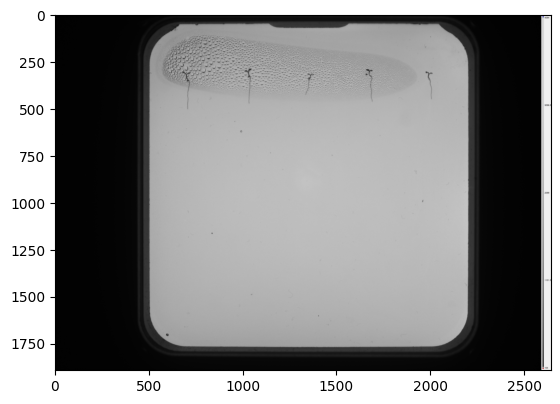

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('data_v2_processed/test/28_05_04.png')
mask = cv2.imread('data_v2_processed/test/28_05_04.tif')

plt.imshow(img)

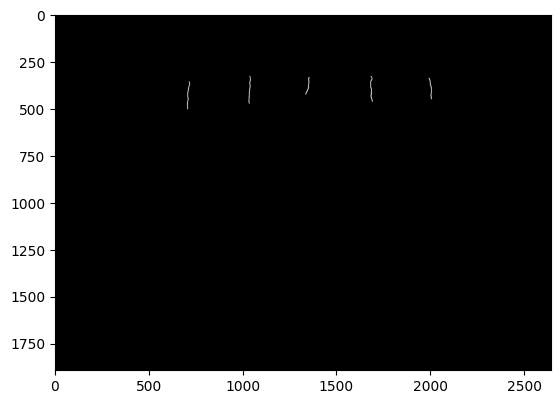

In [6]:
mask = np.array(mask)
mask = 255 * mask

plt.imshow(mask)

In [5]:
# Path to the current image folder
import shutil
base_dir = 'data_v2_processed/test'
target_dir = os.path.join(base_dir, 'images/images')

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Move all .png files into the new subfolder
for filename in os.listdir(base_dir):
    if filename.lower().endswith('.png'):
        src = os.path.join(base_dir, filename)
        dst = os.path.join(target_dir, filename)
        shutil.move(src, dst)

print("All PNG files moved successfully.")

All PNG files moved successfully.


In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

masks_dir = 'data_v2_processed/val/masks/masks'
images_dir = 'data_v2_processed/val/images/images'

for mask_file in os.listdir(masks_dir):
    if mask_file.endswith(".tif"):
        mask_path = os.path.join(masks_dir, mask_file)
        
        image_path = mask_path.replace(".tif", ".png").replace('masks/masks', 'images/images')
        
        # Load the mask image
        mask = Image.open(mask_path)
        mask_array = np.array(mask)
        
        # Check if the maximum pixel intensity is 0
        if mask_array.max() == 0:
            os.remove(mask_path)
            if os.path.exists(image_path):
                os.remove(image_path)
                pass
            else:
                print(f"Didnt find {image_path}")